In [72]:
output_dir = "rsf_temporal_expanded_var_quadratic_loss_3_n_permute_20_pval_1_1_reverse_label_N_all_effect_size_0_1_including_demo_var_1_3_ratio"

In [3]:
# !pip install anamod
# %pip install tsfresh
# %pip install dfply
# %pip install scikit-survival
# !conda install -c sebp scikit-survival

from tsfresh import extract_features
#from scikit-survival.ensemble import RandomSurvivalForest
from sksurv.ensemble import RandomSurvivalForest
#from scikit-survival.util.Surv import from_dataframe
import sksurv
import anamod
from anamod import TemporalModelAnalyzer


In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed


In [5]:

work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project'
#data_file_name = 'data_longi_long_up_to_y15_prior_model_training'
# data_file_name = 'data_longi_ascvd_for_dynamic_deephit'
data_file_name = 'data_longi_expanded_var_for_dynamic_deephit_and_ts_extraction_2'
tsfeatures_filename = 'tsfresh_features_extracted_features_drop_nonunique_dropna_rm_nonrelevant_drop_correlated_dropna_2'

load_dir = work_dir+ '/csv_files'

# load data:
data = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data = data.select_dtypes(include =[np.number])



In [6]:
data

,ID,event,exam_year,time,AGE_Y0,MALE,RACEBLACK,ARMCI,ASMA,BEER,...,PULSE,SMKNW,WGT,WINE,WST,HBM,DBP,SBP,CHNOW,PATCK
0,100033323702,0,0,32.134155,22,1,0,0.0,0,8,...,34,1,161.0,0,75.0,0,74.0,117.0,0,0
1,100033323702,0,2,32.134155,22,1,0,30.0,1,2,...,37,1,159.5,0,80.5,0,69.0,116.0,0,1
2,100033323702,0,5,32.134155,22,1,0,30.0,0,2,...,30,0,169.0,0,78.5,0,73.0,105.0,0,0
3,100033323702,0,7,32.134155,22,1,0,32.5,0,1,...,38,0,174.5,0,81.0,0,72.0,115.0,0,0
4,100033323702,0,15,32.134155,22,1,0,35.0,0,0,...,38,0,178.0,0,82.5,0,71.0,107.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,416817227898,0,2,31.770021,22,1,1,38.0,0,8,...,27,1,199.5,0,95.5,0,63.0,102.0,0,0
19984,416817227898,0,5,31.770021,22,1,1,36.0,0,24,...,35,1,204.0,0,104.0,0,101.0,133.0,0,0
19985,416817227898,0,7,31.770021,22,1,1,36.0,0,28,...,33,1,196.0,0,94.0,0,77.0,133.0,0,0
19986,416817227898,0,10,31.770021,22,1,1,35.5,0,12,...,30,0,192.0,0,92.0,0,66.0,112.0,0,0


In [7]:
data['AGE_Y15'] = data['AGE_Y0']+15
data = data.drop(['AGE_Y0'], axis = 1)

In [8]:
data_ts = data.loc[:, ~data.columns.isin(['Unnamed: 0', 'event','time'])]
# data_ts.rename(columns={"exam_year": "time"}
data_ts


,ID,exam_year,MALE,RACEBLACK,ARMCI,ASMA,BEER,BMI,CANCR,CGTDY,...,SMKNW,WGT,WINE,WST,HBM,DBP,SBP,CHNOW,PATCK,AGE_Y15
0,100033323702,0,1,0,0.0,0,8,23.359130,0,4,...,1,161.0,0,75.0,0,74.0,117.0,0,0,37
1,100033323702,2,1,0,30.0,1,2,23.405217,0,2,...,1,159.5,0,80.5,0,69.0,116.0,0,1,37
2,100033323702,5,1,0,30.0,0,2,24.799258,0,0,...,0,169.0,0,78.5,0,73.0,105.0,0,0,37
3,100033323702,7,1,0,32.5,0,1,25.317815,0,0,...,0,174.5,0,81.0,0,72.0,115.0,0,0,37
4,100033323702,15,1,0,35.0,0,0,25.680330,0,0,...,0,178.0,0,82.5,0,71.0,107.0,0,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,416817227898,2,1,1,38.0,0,8,27.527512,0,15,...,1,199.5,0,95.5,0,63.0,102.0,0,0,37
19984,416817227898,5,1,1,36.0,0,24,27.993984,0,12,...,1,204.0,0,104.0,0,101.0,133.0,0,0,37
19985,416817227898,7,1,1,36.0,0,28,26.896181,0,15,...,1,196.0,0,94.0,0,77.0,133.0,0,0,37
19986,416817227898,10,1,1,35.5,0,12,25.499701,0,0,...,0,192.0,0,92.0,0,66.0,112.0,0,0,37


In [9]:
data_ts.columns.difference(['ID', 'exam_year']).values

array(['AGE_Y15', 'ARMCI', 'ASMA', 'BEER', 'BMI', 'CANCR', 'CGTDY',
       'CHNOW', 'CHOL', 'DBP', 'DFPAY', 'DIAB', 'ED', 'GALL', 'GLU',
       'HBM', 'HDL', 'KIDNY', 'LDL', 'LIFE', 'LIQR', 'LIVER', 'MALE',
       'MENTL', 'NPREG', 'NTRIG', 'PATCK', 'PSTYR', 'PULSE', 'RACEBLACK',
       'SBP', 'SMKNW', 'WGT', 'WINE', 'WST'], dtype=object)

In [10]:
varying_var = data_ts.columns.difference(['ID', 'exam_year']).values

n_exam = 6
n_vars = len(varying_var)
n_subjects = len(np.unique(data_ts['ID'].values))
exam_year_list = [0, 2, 5, 7, 10, 15]

def convert_long_format_to_3d_matrix(data_ts_, n_exam_, n_varying_vars_, n_subjects_, varying_var_):

    desired_X = np.array([[[float(0) for k in range(n_exam_)] for j in range(n_varying_vars_)] for i in range(n_subjects_)])
    for i in range(0,n_varying_vars_):
        var_wide_df = data_ts_.pivot(index='ID', columns='exam_year', values=varying_var_[i])
        var_wide_df_locf = var_wide_df.T.fillna(method='ffill').T
        var_wide_df_locf_nocb = var_wide_df_locf.T.fillna(method='bfill').T

        var_wide_locf_matrix = var_wide_df_locf_nocb.values
#        var_wide_locf_matrix = var_wide_df_locf.values
        desired_X[:,i,:] = var_wide_locf_matrix.astype(float)
    return(desired_X)


In [11]:
desired_X = convert_long_format_to_3d_matrix(data_ts_ = data_ts, n_exam_ = n_exam, n_varying_vars_ = n_vars, n_subjects_ = n_subjects
                                            , varying_var_ = varying_var)


In [12]:
# First variable for all subjects (row: subject, column: measurement over time)
desired_X[:,0,:]

array([[37., 37., 37., 37., 37., 37.],
       [43., 43., 43., 43., 43., 43.],
       [35., 35., 35., 35., 35., 35.],
       ...,
       [42., 42., 42., 42., 42., 42.],
       [42., 42., 42., 42., 42., 42.],
       [37., 37., 37., 37., 37., 37.]])

In [13]:
unique_ids_arr = np.unique(data_ts['ID'])
unique_ids_arr.shape

(3539,)

In [14]:
def convert_3d_to_long_format(X, n_subjects_, varying_var_,exam_year_list_, unique_ids_arr_):
    for subject in range(0, n_subjects_):
        if (subject == 0):
            all_subject_long_format = X[subject,:,:].T
        else:
            subject_long_format = desired_X[subject,:,:].T
            all_subject_long_format = np.concatenate((all_subject_long_format, subject_long_format))
    all_subject_long_format_df = pd.DataFrame(all_subject_long_format)
    all_subject_long_format_df.columns = varying_var_
    all_subject_long_format_df.insert(loc = 0, column = 'exam_year',
              value = exam_year_list_*n_subjects_)
    all_subject_long_format_df.insert(loc = 0, column = 'ID',
              value = [val for val in unique_ids_arr_ for _ in range(len(exam_year_list_))])
    return(all_subject_long_format_df[data_ts.columns.values])



# reconstructed_data_ts_long_format = convert_3d_to_long_format(X = desired_X, n_subjects_ = n_subjects
#                                                              ,varying_var_ = varying_var
#                                                              ,exam_year_list_ = exam_year_list
#                                                              ,unique_ids_arr_ =unique_ids_arr)



# reconstructed_data_ts_long_format

In [15]:

reconstructed_data_ts_long_format = convert_3d_to_long_format(X = desired_X, n_subjects_ = n_subjects
                                                             ,varying_var_ = varying_var
                                                             ,exam_year_list_ = exam_year_list
                                                             ,unique_ids_arr_ =unique_ids_arr)



reconstructed_data_ts_long_format

,ID,exam_year,MALE,RACEBLACK,ARMCI,ASMA,BEER,BMI,CANCR,CGTDY,...,SMKNW,WGT,WINE,WST,HBM,DBP,SBP,CHNOW,PATCK,AGE_Y15
0,100033323702,0,1.0,0.0,0.0,0.0,8.0,23.359130,0.0,4.0,...,1.0,161.0,0.0,75.0,0.0,74.0,117.0,0.0,0.0,37.0
1,100033323702,2,1.0,0.0,30.0,1.0,2.0,23.405217,0.0,2.0,...,1.0,159.5,0.0,80.5,0.0,69.0,116.0,0.0,1.0,37.0
2,100033323702,5,1.0,0.0,30.0,0.0,2.0,24.799258,0.0,0.0,...,0.0,169.0,0.0,78.5,0.0,73.0,105.0,0.0,0.0,37.0
3,100033323702,7,1.0,0.0,32.5,0.0,1.0,25.317815,0.0,0.0,...,0.0,174.5,0.0,81.0,0.0,72.0,115.0,0.0,0.0,37.0
4,100033323702,10,1.0,0.0,32.5,0.0,1.0,25.317815,0.0,0.0,...,0.0,174.5,0.0,81.0,0.0,72.0,115.0,0.0,0.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21229,416817227898,2,1.0,1.0,38.0,0.0,8.0,27.527512,0.0,15.0,...,1.0,199.5,0.0,95.5,0.0,63.0,102.0,0.0,0.0,37.0
21230,416817227898,5,1.0,1.0,36.0,0.0,24.0,27.993984,0.0,12.0,...,1.0,204.0,0.0,104.0,0.0,101.0,133.0,0.0,0.0,37.0
21231,416817227898,7,1.0,1.0,36.0,0.0,28.0,26.896181,0.0,15.0,...,1.0,196.0,0.0,94.0,0.0,77.0,133.0,0.0,0.0,37.0
21232,416817227898,10,1.0,1.0,35.5,0.0,12.0,25.499701,0.0,0.0,...,0.0,192.0,0.0,92.0,0.0,66.0,112.0,0.0,0.0,37.0


In [16]:
# load tsfeatures data:

# tsfeatures = pd.read_csv(work_dir+ '/csv_files'+'/'+'tsfresh_features_drop_nonunique_drop_na_relevant_df_drop_correlated'+'.csv')
tsfeatures = pd.read_csv(work_dir+ '/csv_files'+'/'+tsfeatures_filename +'.csv')
tsfeatures = tsfeatures.select_dtypes(include =[np.number])
tsfeatures_vars = tsfeatures.columns[1:].values


In [17]:
# data_outcome_and_static = data.loc[data['exam_year'] == 15][['ID','event','time','AGE_Y0','MALE','RACEBLACK']]
data_outcome_and_static = data.drop_duplicates(subset='ID', keep='last')[['ID','event','time']]
data_outcome_and_static['time'] = data_outcome_and_static['time']-15
data_outcome_and_static = data_outcome_and_static[['ID','event','time']]
data_outcome_and_static

,ID,event,time
4,100033323702,0,17.134155
10,100056526386,0,17.142368
16,100061300991,0,17.427105
22,100080112533,0,17.057495
28,100101126081,0,17.424367
...,...,...,...
19966,416752023336,0,16.704312
19972,416761219907,0,16.674196
19976,416783315386,0,16.690623
19981,416796224310,0,16.761807


In [18]:
import tsfresh
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(tsfeatures.iloc[:,1:])

In [19]:
# kind_to_fc_parameters

In [20]:
def long_format_to_tsfeatures_df(df, tsfeatures_vars_):
    # extract all ts featurse using tsfresh:
    extracted_features = extract_features(df, column_id="ID", column_sort="exam_year"
                                         , kind_to_fc_parameters = kind_to_fc_parameters
                                         )

    # filter out vars used in the RSF-tsfresh model:
    extracted_features_filter_features_in_model = extracted_features[tsfeatures_vars_]
    extracted_features_filter_features_in_model.reset_index(level=0, inplace=True)
    extracted_features_filter_features_in_model = extracted_features_filter_features_in_model.rename(columns={'index': 'ID'})
    
    extracted_features_filter_features_in_model_plus_demo_vars = extracted_features_filter_features_in_model.merge(df.drop_duplicates(subset=['ID'])[['ID','AGE_Y15','MALE','RACEBLACK']], on = 'ID', how = 'inner')

    
    return(extracted_features_filter_features_in_model_plus_demo_vars)


In [21]:
y_all = sksurv.util.Surv.from_dataframe('event', 'time', data_outcome_and_static)
#y_all = from_dataframe('event', 'time', data_outcome_and_static)
y_all.shape

(3539,)

In [22]:
def rsf_ts_reformat(X):
    # given a 3d matrix feature space format, convert to the data format ready to plug into RSF:
    
    # convert X from 3d matrix to long format:
    reconstructed_data_ts_long_format = convert_3d_to_long_format(X 
                                                                 , n_subjects_ = n_subjects
                                                                 ,varying_var_ = varying_var
                                                                 ,exam_year_list_ = exam_year_list
                                                                 ,unique_ids_arr_ = unique_ids_arr)

    # convert from long format to format readily to feed into RSF-tsfeatures:
    # by computing ts features from long format data, filter necessary features
    tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)
    #data_for_rsf = data_outcome_and_static[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']].merge(tsfeatures_for_rsf_df, on = 'ID', how = 'inner')
    #featurespace_df_for_rsf = data_for_rsf.drop(['ID','time','event'],axis =1)
    
    featurespace_df_for_rsf = tsfeatures_for_rsf_df #since tsfeatures_for_rsf_df already include demo vars
    
    return(featurespace_df_for_rsf)

In [23]:
# reconstructed_data_ts_long_format = convert_3d_to_long_format(desired_X
#                                                                  , n_subjects_ = n_subjects
#                                                                  ,varying_var_ = varying_var
#                                                                  ,exam_year_list_ = exam_year_list
#                                                                  ,unique_ids_arr_ = unique_ids_arr)
# reconstructed_data_ts_long_format
# tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)


Feature Extraction: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


In [24]:
# tsfeatures_for_rsf_df

,ID,ARMCI__absolute_sum_of_changes,ARMCI__benford_correlation,"ARMCI__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","ARMCI__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","ARMCI__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)",BMI__benford_correlation,"BMI__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0","BMI__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","BMI__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",...,"WST__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","WST__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","WST__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","WST__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","WST__fft_coefficient__attr_""abs""__coeff_1","WST__fft_coefficient__attr_""real""__coeff_1",WST__time_reversal_asymmetry_statistic__lag_1,AGE_Y15,MALE,RACEBLACK
0,100033323702,35.0,0.062915,1.250000,1.337792,17.661069,0.295657,0.046087,0.253640,13.840900,...,3.875000,3.26,45.700954,89.761349,5.766281,-4.25,25437.87500,37.0,1.0,0.0
1,100056526386,5.0,0.062915,0.333333,21.863903,41.852430,0.198691,-0.594305,1.720815,16.813338,...,13.300000,13.30,52.663450,101.608178,18.513509,-12.75,88386.62500,43.0,1.0,1.0
2,100061300991,6.0,0.122661,1.250000,17.024827,34.271592,0.309793,1.299853,1.304582,13.793467,...,12.546875,11.86,44.461321,91.507800,25.238859,-17.50,135075.50000,35.0,1.0,1.0
3,100080112533,5.0,0.308407,1.000000,16.852195,32.297843,0.954077,0.293182,0.794196,10.448176,...,6.421875,5.44,39.022509,78.008585,20.952327,-6.50,83490.46875,35.0,1.0,1.0
4,100101126081,11.0,-0.158665,1.750000,27.262257,53.936772,-0.001285,2.324742,4.963703,21.580801,...,18.666667,18.56,57.314080,112.837448,20.808652,-18.50,98380.00000,43.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,416752023336,6.0,0.122661,1.000000,17.701187,34.774055,0.295657,0.000000,1.804968,13.322870,...,6.421875,8.20,49.221086,97.821491,10.148892,-3.50,66973.09375,41.0,1.0,1.0
3535,416761219907,6.0,0.295657,1.200000,15.249138,29.377708,0.295657,1.449927,1.572485,12.403987,...,4.125000,5.26,38.653082,75.121563,13.313527,-5.50,41380.50000,45.0,0.0,0.0
3536,416783315386,2.5,0.295657,0.500000,16.566214,31.207463,0.470842,-0.157282,0.059310,12.166482,...,2.800000,2.80,44.409905,84.956912,10.440307,9.50,-20167.50000,42.0,0.0,0.0
3537,416796224310,11.5,-0.001285,2.300000,19.673671,39.001794,0.137261,0.000000,15.288124,16.556631,...,63.166667,66.34,47.634664,94.875549,56.817691,-50.75,221244.31250,42.0,0.0,1.0


In [25]:

from sksurv.ensemble import RandomSurvivalForest

class RSF_TS():
    """Class implementing model API required by anamod"""
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.rsf_ts = RandomSurvivalForest(**kwargs)
        
    def fit(self, X, y=None):
        
        X_rsf_format = rsf_ts_reformat(X)
        self.rsf_ts.fit(X_rsf_format, y)
        
    def predict(self, X):
        """Perform prediction on input X (comprising one or more instances)"""
        # return self.ground_truth_model.predict(X, noise=self.noise_multiplier)
        X_rsf_format = rsf_ts_reformat(X)
        # preds = self.rsf_ts.predict(X_rsf_format)
        surv = self.rsf_ts.predict_survival_function(X_rsf_format, return_array = True)
        preds = surv[:, -1]
        return(preds)
    
    def score(self, X, y_label):
        X_rsf_format = rsf_ts_reformat(X)
        c_index = self.rsf_ts.score(X_rsf_format, y_label)
        return(c_index)

In [26]:
unique_ids_arr_all = np.unique(data['ID'])


In [27]:
# all subjects with an event:
event_idx = data_outcome_and_static.reset_index().loc[data_outcome_and_static.reset_index()['event'] ==1].index.values
non_event_idx = data_outcome_and_static.reset_index().loc[data_outcome_and_static.reset_index()['event'] ==0].index.values
event_idx

array([   6,   39,   41,   58,   70,   87,   99,  121,  127,  148,  185,
        190,  237,  265,  291,  302,  312,  321,  323,  335,  340,  346,
        353,  354,  368,  371,  376,  382,  391,  398,  399,  404,  410,
        411,  423,  450,  462,  465,  470,  509,  512,  516,  524,  540,
        567,  568,  571,  582,  600,  603,  604,  617,  618,  619,  629,
        646,  652,  667,  693,  695,  699,  710,  729,  751,  811,  847,
        863,  903,  908,  913,  915,  947,  970, 1015, 1023, 1056, 1064,
       1068, 1076, 1115, 1120, 1130, 1157, 1173, 1206, 1223, 1278, 1309,
       1310, 1338, 1342, 1371, 1377, 1379, 1394, 1395, 1413, 1427, 1451,
       1459, 1467, 1477, 1488, 1492, 1523, 1545, 1564, 1572, 1576, 1592,
       1596, 1664, 1669, 1684, 1696, 1710, 1714, 1726, 1753, 1760, 1779,
       1809, 1821, 1830, 1884, 1899, 1966, 1972, 2026, 2047, 2069, 2076,
       2126, 2128, 2141, 2150, 2153, 2158, 2178, 2210, 2231, 2248, 2347,
       2363, 2455, 2478, 2480, 2498, 2521, 2532, 25

In [28]:
# combine indices of all subjects with event and a X times number of subjects without event
event_non_event_ratio = 3
N_exp = np.concatenate([event_idx, non_event_idx[:event_non_event_ratio*len(event_idx)]])
len(N_exp)

724

In [29]:

seed(1)
n_subjects= len(N_exp)
unique_ids_arr = unique_ids_arr_all[N_exp]

RSF_TS_obj_N_exp = RSF_TS(n_estimators=1001,
                   min_samples_split=10,
                   min_samples_leaf=15,
                   max_features="sqrt",
                   n_jobs=-1,
                   random_state=20)
#RSF_TS_obj_N_exp.fit(desired_X, y_all) 
RSF_TS_obj_N_exp.fit(desired_X[N_exp,:,:], y_all[N_exp]) 

Feature Extraction: 100%|██████████| 50/50 [00:02<00:00, 17.23it/s]


In [30]:
data_outcome_and_static.iloc[N_exp,:]['event'].value_counts()

0    543
1    181
Name: event, dtype: int64

In [31]:
y_pred_N_exp = RSF_TS_obj_N_exp.predict(desired_X[N_exp,:,:])

Feature Extraction: 100%|██████████| 50/50 [00:02<00:00, 16.73it/s]


/home/idies/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_hat', ylabel='Density'>

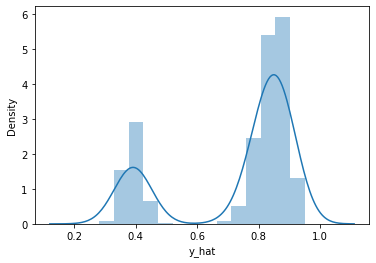

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_df =pd.DataFrame(y_pred_N_exp, columns = ['y_hat'])
sns.distplot(y_pred_df.y_hat)

In [33]:
# execfile("./model_analyzer_1.py")
# exec(open("./model_analyzer_1.py").read())
exec(open("./model_analyzer_n_permut_20_effect_size_0_1.py").read())


In [ ]:
# Analyze the model
import time
start = time.time()

rsf_analyzer = TemporalModelAnalyzer_1(RSF_TS_obj_N_exp, desired_X[N_exp,:,:], 1-data_outcome_and_static.iloc[N_exp,:]['event'], output_dir=output_dir)
features = rsf_analyzer.analyze()

end = time.time()
print(end - start)

Feature Extraction:  54%|█████▍    | 27/50 [00:02<00:03,  7.53it/s]

In [ ]:
print((end - start)/3600)


In [ ]:
features_df = pd.read_csv(output_dir+'/'+'feature_importance.csv')
features_df['normalized_score'] = (abs(features_df['importance_score'])-min(abs(features_df['importance_score'])))/(max(abs(features_df['importance_score']))-min(abs(features_df['importance_score'])))
features_df.insert(loc=0, column='feature_name', value=varying_var)
features_df.loc[features_df['window_ordering_pvalue'] == 1, 'window_ordering_important'] = False
features_df

In [ ]:

#def visualize_temporal(args, features, sequence_length):

"""Visualize temporal feature importance results"""

from matplotlib import patches 
import seaborn as sns

sequence_length = n_exam
exam_label_arr = ['Y0', 'Y2', 'Y5', 'Y7', 'Y10', 'Y15']

# pylint: disable = invalid-name, too-many-locals
# features = list(filter(lambda feature: feature.important, features_N_exp))  # Filter out unimportant features
imp_features_df = features_df.loc[features_df['important'] == True]
num_features = imp_features_df.shape[0]

if num_features == 0:
    print("No important features identified, skipping window feature importance window visualization.")
#    return

sns.set(rc={'figure.figsize': (sequence_length / 2 *3, 2 + num_features / 2), 'figure.dpi': 300,
            #'font.family': 'Serif', 'font.serif': 'Palatino',
            'axes.titlesize': 24-14, 'axes.labelsize': 20-4, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

# features = sorted(features, key=lambda feature: feature.window_effect_size, reverse=True)

sort_imp_features_df = imp_features_df.sort_values(by='normalized_score',ascending=False, ignore_index=True)

sort_imp_features_df

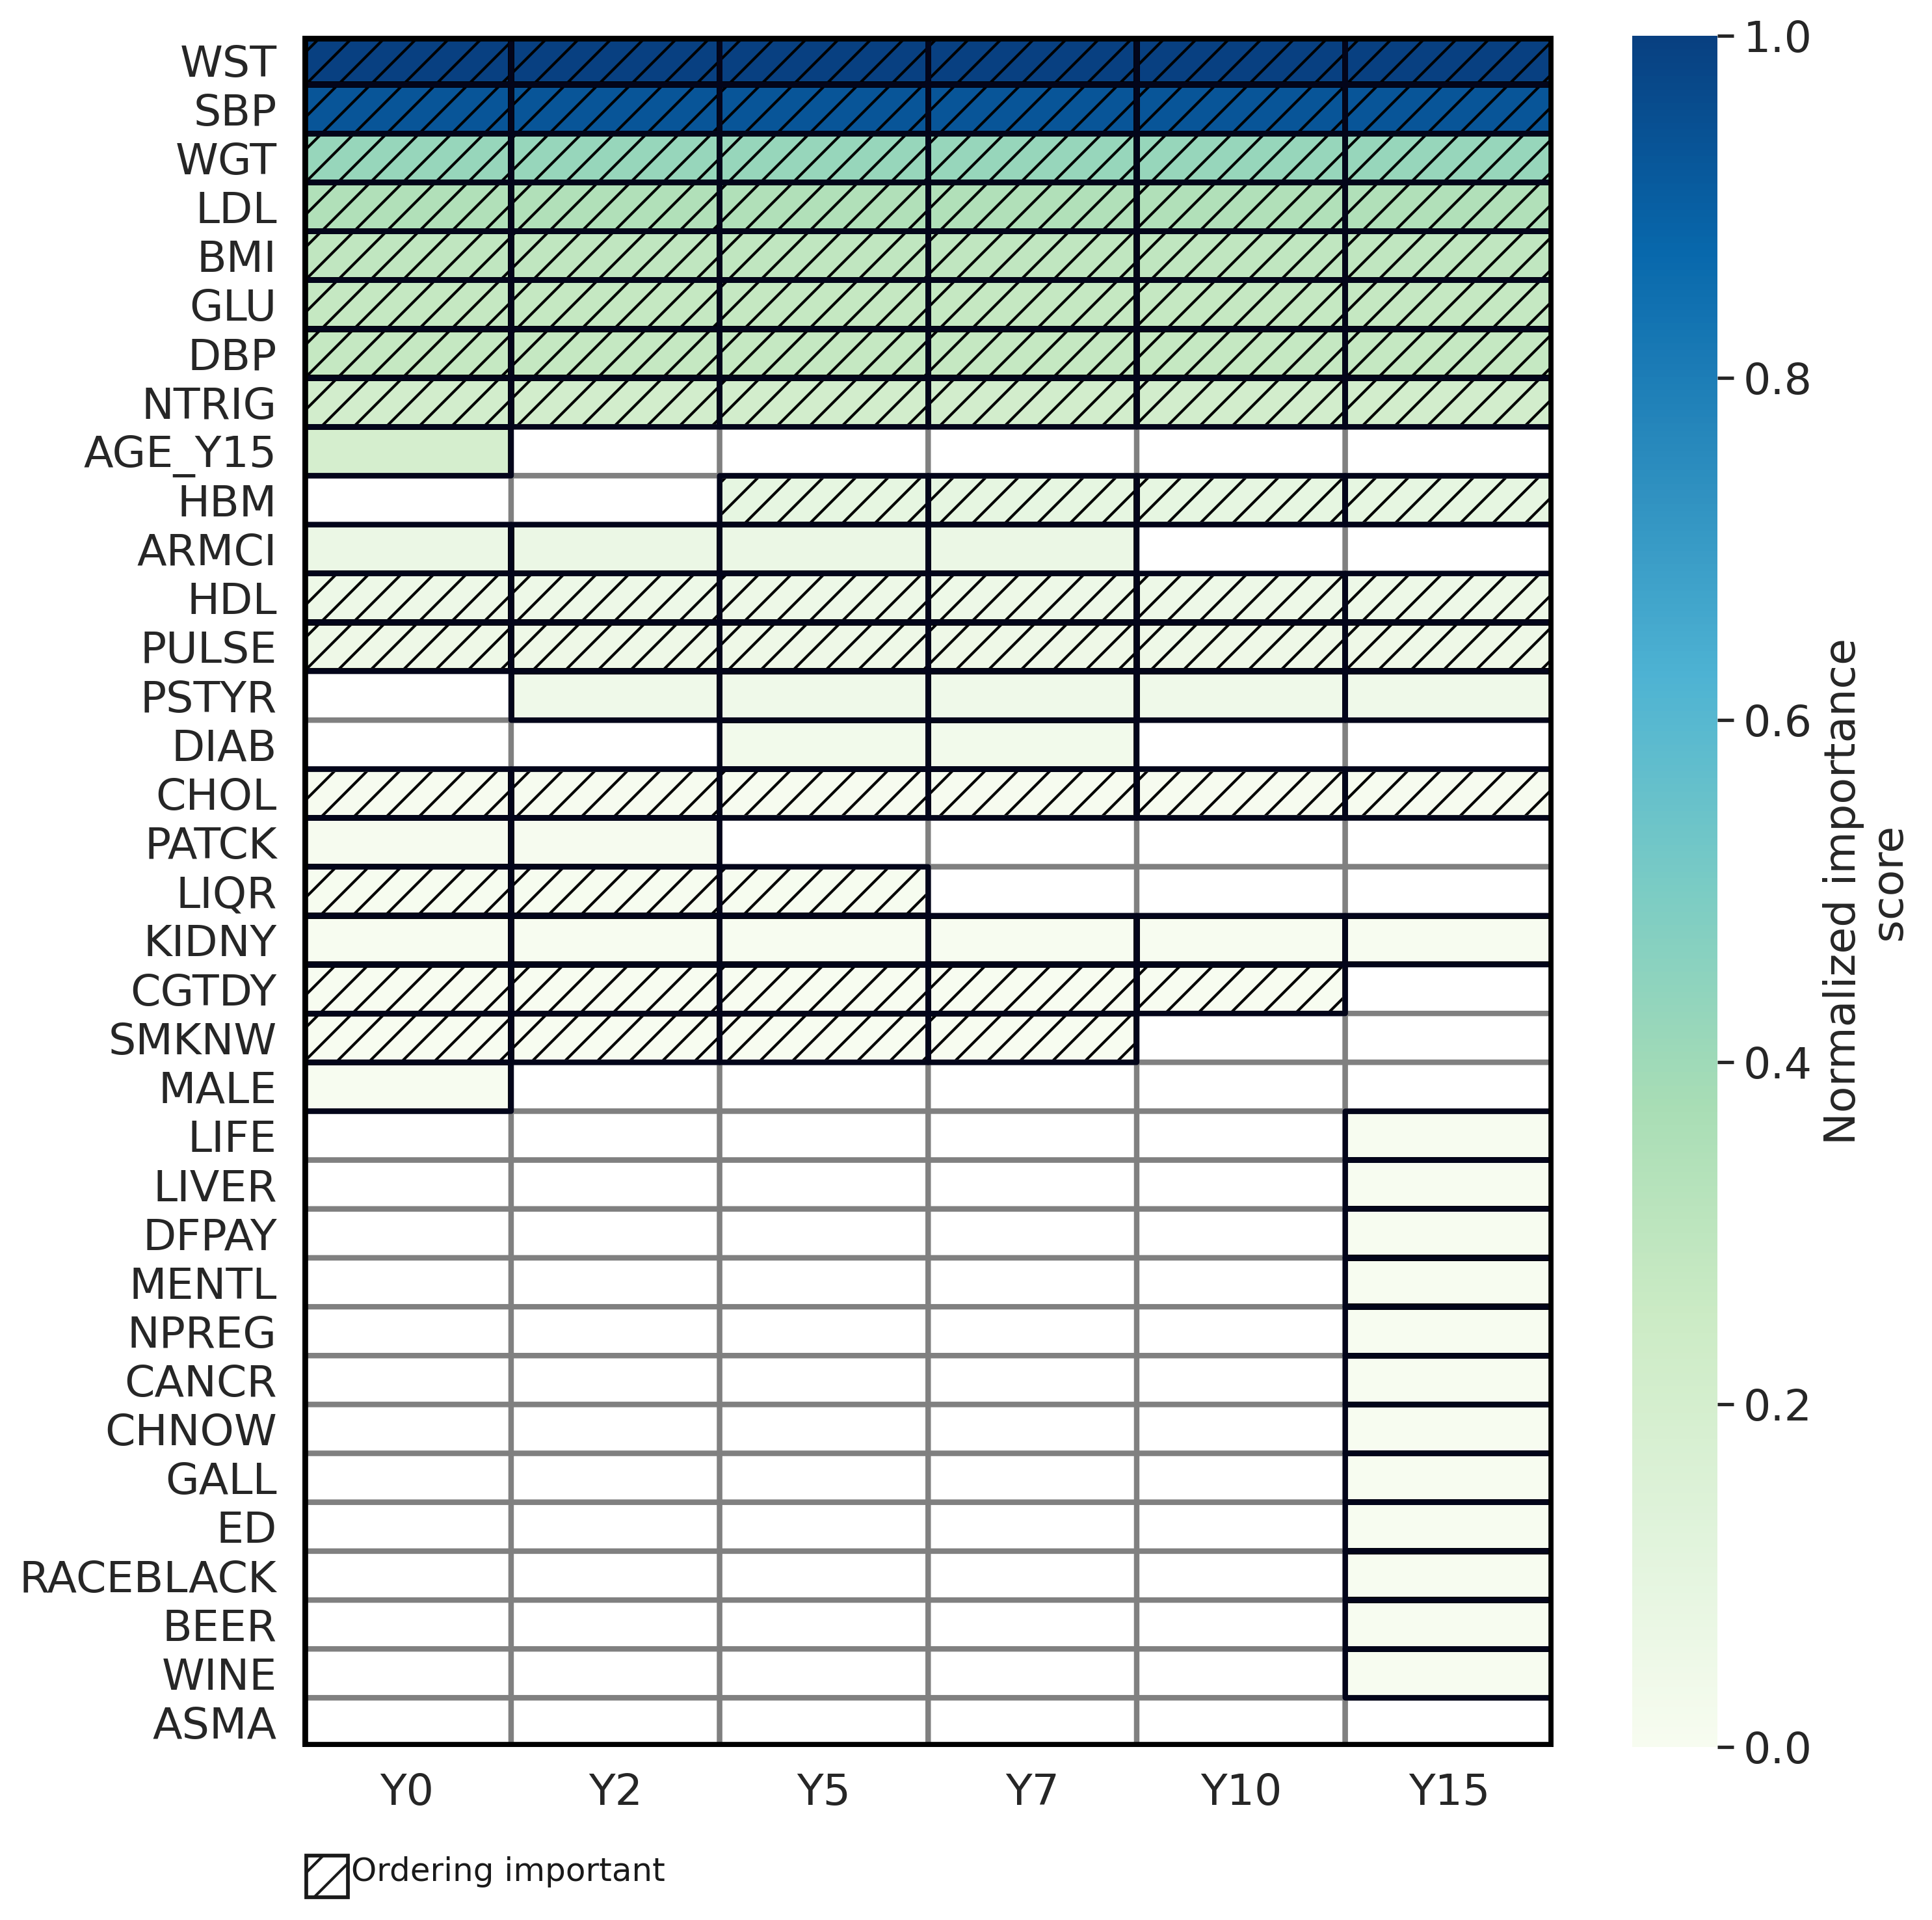

In [40]:

def plot_vimp_heatmap(sort_imp_features_df_):
    num_features_ = sort_imp_features_df_.shape[0]
    
    data_ = np.zeros((num_features_, sequence_length))
    hatchdata_ = np.zeros((num_features_, sequence_length)) 

    # labels = [feature.name for feature in features]
    labels_ = sort_imp_features_df_['feature_name']

    for feature_ in range(len(labels_)):
        if sort_imp_features_df_['window'][feature_]:
            if sort_imp_features_df_['window'][feature_][1].isdigit():  
                left = int(sort_imp_features_df_['window'][feature_][1])
                right = int(sort_imp_features_df_['window'][feature_][4])
            else:
                left = int(sort_imp_features_df_['window'][feature_][5])
                right = int(5)
            data_[feature_, left:right+1] = sort_imp_features_df_['normalized_score'][feature_]
        if sort_imp_features_df_['window_ordering_important'][feature_] == True:
            hatchdata_[feature_, left: right + 1] = 1


    _, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [num_features_, 1]})


    sns.set(rc={'figure.figsize': (10, 10), 'figure.dpi': 300,
                #'font.family': 'Serif', 'font.serif': 'Palatino',
                'axes.titlesize': 24-14, 'axes.labelsize': 20-4, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

    fig = sns.heatmap(data_, yticklabels=labels_, xticklabels= exam_label_arr#np.arange(1, sequence_length + 1)
                , mask=(data_ == 0), linewidth=2, linecolor="black"
                , cmap="GnBu" #"YlOrRd"
                , cbar_kws=dict(label="Normalized importance\n score"), ax=axes[0])


    # Border lines
    axes[0].axhline(y=0, color='black', linewidth=4)
    axes[0].axhline(y=num_features_, color='black', linewidth=4)
    axes[0].axvline(x=0, color='black', linewidth=4)
    axes[0].axvline(x=sequence_length, color='black', linewidth=4)
    # Labels
    # axes[0].set_title("Temporal Feature Importance")
    # axes[0].set_xlabel("Timesteps")
    # axes[0].set_ylabel("Important\nFeatures")
    # Hatch texture for ordering relevance
    x = np.arange(sequence_length + 1)
    y = np.arange(num_features_ + 1)
    z = np.ma.masked_equal(hatchdata_, 0)
    axes[0].pcolor(x, y, z, hatch='//', alpha=0.)
    # Grey foreground for non-relevant timesteps
    z = np.ma.masked_not_equal(data_, 0)
    axes[0].pcolor(x, y, z, cmap="Greys", linewidth=2, edgecolors="Grey")
    # Fix edges of relevant timesteps
    z = np.ma.masked_equal((data_ != 0), 0)
    axes[0].pcolor(x, y, z, linewidth=2, edgecolor="k", facecolor="none", alpha=1.0)

    # Legend
    axes[1].set_aspect(1, anchor="W")
    axes[1].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor="w", edgecolor="k", linewidth=4, hatch="//"))
    axes[1].annotate("Ordering important", (1, 0.4), color="k"
                     # , weight="bold"
                     , fontsize=12)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])

    # Plot
    plt.tight_layout()

    #plt.savefig("./rsf_temporal/feature_importance_windows_replot.png")

    
# plot_vimp_heatmap(sort_imp_features_df_filter_window_pval)

# sort_imp_features_df_filter_window_pval = sort_imp_features_df.loc[sort_imp_features_df['window_pvalue'] <1].reset_index()
# #sort_imp_features_df_filter_window_pval = sort_imp_features_df.loc[sort_imp_features_df['window_pvalue'] <1].reset_index()
# var_oi_list = ['SBP', 'WST', 'BMI', 'WGT', 'SMKNW', 'HDL', 'ARMCI', 'LDL', 'LIQR',
#        'DBP', 'GLU', 'NTRIG', 'HBM', 'CGTDY', 'PSTYR', 'CHOL', 'PULSE',
#        'PATCK', 'LIFE', 'DFPAY']

# sort_imp_features_df_var_oi = sort_imp_features_df.loc[sort_imp_features_df['feature_name'].isin(var_oi_list)].reset_index(drop= True)
# plot_vimp_heatmap(sort_imp_features_df_var_oi)

plot_vimp_heatmap(sort_imp_features_df)
plt.savefig('./'+output_dir+'/feature_importance_windows_replot_var_oi.png')


In [63]:
# Change importance score of ASMA to be the same as the other non-importance variables (such as BEER):
features_df.at[2, 'importance_score'] = features_df.at[3, 'importance_score']
features_df['normalized_score'] = (abs(features_df['importance_score'])-min(abs(features_df['importance_score'])))/(max(abs(features_df['importance_score']))-min(abs(features_df['importance_score'])))
#features_df.insert(loc=0, column='feature_name', value=varying_var)
features_df.loc[features_df['window_ordering_pvalue'] == 1, 'window_ordering_important'] = False

imp_features_df = features_df.loc[features_df['important'] == True]
sort_imp_features_df = imp_features_df.sort_values(by='normalized_score',ascending=False, ignore_index=True)
sort_imp_features_df

,feature_name,name,important,importance_score,pvalue,ordering_important,ordering_pvalue,window,window_important,window_importance_score,window_pvalue,window_ordering_important,window_ordering_pvalue,normalized_score
0,WST,34,True,4.399931e-05,0.333333,True,0.047619,"(0, 5)",True,4.265163e-05,0.047619,True,0.047619,1.000000
1,SBP,30,True,4.094289e-05,0.333333,True,0.047619,"(0, 5)",True,4.943991e-05,0.047619,True,0.047619,0.930535
2,WGT,32,True,1.870645e-05,0.333333,True,0.047619,"(0, 5)",True,1.871058e-05,0.047619,True,0.047619,0.425153
3,LDL,18,True,1.512656e-05,0.333333,True,0.095238,"(0, 5)",True,1.694159e-05,0.095238,True,0.047619,0.343791
4,BMI,4,True,1.278215e-05,0.333333,True,0.095238,"(0, 5)",True,1.482210e-05,0.095238,True,0.047619,0.290508
5,GLU,14,True,1.217042e-05,0.333333,True,0.238095,"(0, 5)",True,1.452745e-05,0.095238,True,0.095238,0.276605
6,DBP,9,True,1.211124e-05,0.333333,True,0.047619,"(0, 5)",True,1.282571e-05,0.047619,True,0.047619,0.275260
7,NTRIG,25,True,9.360064e-06,0.333333,True,0.095238,"(0, 5)",True,1.316155e-05,0.095238,True,0.047619,0.212732
8,AGE_Y15,0,True,8.644218e-06,0.357143,True,1.000000,"(0, 0)",True,7.918320e-06,0.285714,False,1.000000,0.196463
9,HBM,15,True,3.987533e-06,0.357143,True,0.190476,"(2, 5)",True,3.894138e-06,0.190476,True,0.523810,0.090627


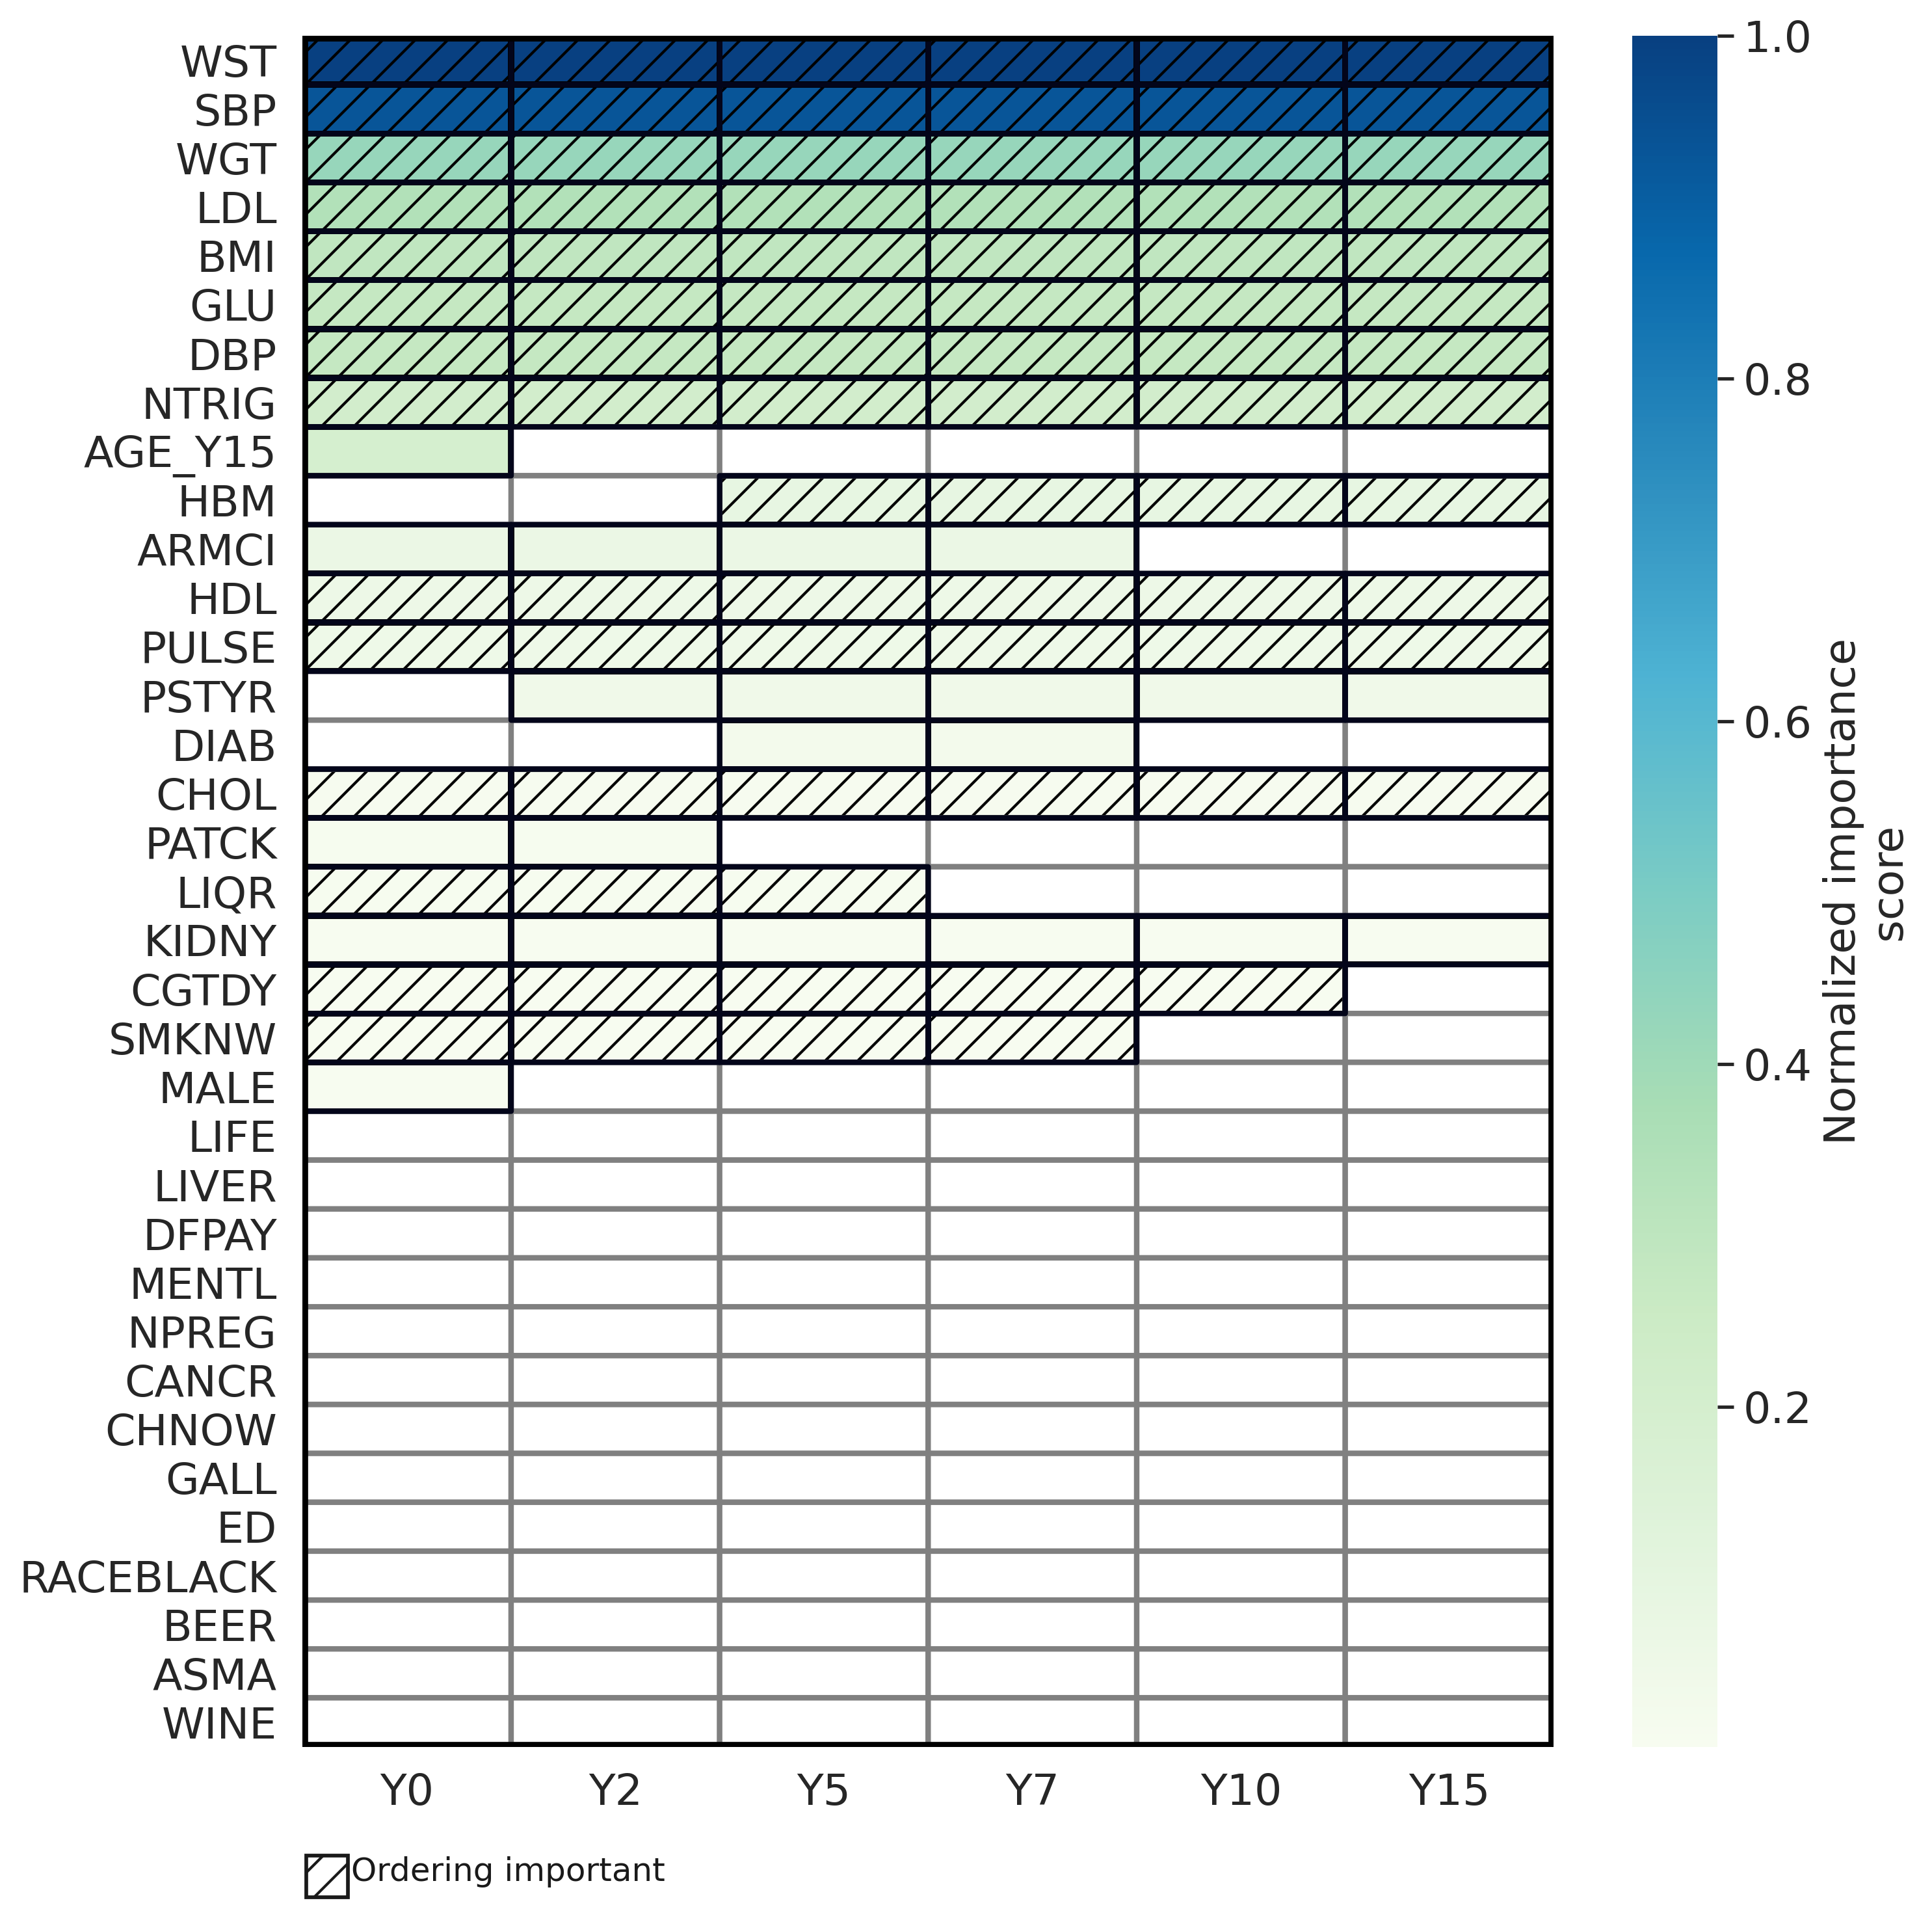

In [76]:
plot_vimp_heatmap(sort_imp_features_df)
plt.savefig('feature_importance_windows_replot_var_oi_1.png')
